In [ ]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as sm
import os
import random

%matplotlib inline
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Using file from the drive
from google.colab import drive
drive.mount('/content/drive')
!ls
df = pd.read_csv('/content/drive/Shared drives/Data Science for All - Womens Summit/Data/US Crunchbase Companies.csv')
# df.head()

Mounted at /content/drive
drive  sample_data


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,18,26,28,32,33,34,38,39,41,42,43,44,45,46,53,56,74,76,78,82,83,90,94,96,97,101,102,103,104,105,107,108,109,110,111,112,114,115,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Women Founded or Led businesses
df_women = df[df['Diversity Spotlight (US Only)'].astype(str).str.contains("Women")]
len(df_women)

6019

In [ ]:
df_women = df_women[['Total Funding Amount Currency (in USD)', 'Estimated Revenue Range', 'Number of Investments',
                 'Number of Exits (IPO)']]

In [ ]:
## CLEANING
## Step 1: Cleaning and Formatting dataset to be used
df_women.rename(columns={'Estimated Revenue Range': 'Estimated Revenue >= 1M'}, inplace=True)



In [ ]:
#revenue cleaned
## 1 if greater than 1M; 0 otherwise
df_women.loc[(df_women['Estimated Revenue >= 1M'] == 'Less than $1M'),'Estimated Revenue >= 1M']=0
df_women.loc[~(df_women['Estimated Revenue >= 1M'] == 0),'Estimated Revenue >= 1M']=1
df_women

,Total Funding Amount Currency (in USD),Estimated Revenue >= 1M,Number of Investments,Number of Exits (IPO)
63,NaN,1,NaN,NaN
84,NaN,1,NaN,NaN
87,50000.0,0,NaN,NaN
105,NaN,1,NaN,NaN
106,500000.0,1,NaN,NaN
...,...,...,...,...
108896,NaN,0,NaN,NaN
108924,NaN,1,NaN,NaN
108951,NaN,0,NaN,NaN
108962,NaN,0,NaN,NaN


In [ ]:
# Remove string "Total Funding Amount Currency (in USD)" from the list of values
# df_target = df_women[df_women['Total Funding Amount Currency (in USD)'] != "Total Funding Amount Currency (in USD)"]
df_target= df_women

# Find 25%, 50%, 75% quartiles of the non-empty Total Funding Amount Currency (in USD)
low_value = df_target['Total Funding Amount Currency (in USD)'].dropna().astype('float').quantile(0.25)
medium_value = df_target['Total Funding Amount Currency (in USD)'].dropna().astype('float').quantile(0.5)
high_value = df_target['Total Funding Amount Currency (in USD)'].dropna().astype('float').quantile(0.75)
print("The 25% quartile of non-empty total funding amount:", low_value)
print("The 50% quartile of non-empty total funding amount:", medium_value)
print("The 75% quartile of non-empty total funding amount:", high_value)

The 25% quartile of non-empty total funding amount: 400000.0
The 50% quartile of non-empty total funding amount: 2200000.0
The 75% quartile of non-empty total funding amount: 10500000.0


In [ ]:
df_women['Total Funding Amount Currency (in USD)']

63             NaN
84             NaN
87         50000.0
105            NaN
106       500000.0
            ...   
108896         NaN
108924         NaN
108951         NaN
108962         NaN
108964         NaN
Name: Total Funding Amount Currency (in USD), Length: 6019, dtype: float64

In [ ]:
#KNN imputation

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

X_train = df_women[['Estimated Revenue >= 1M','Number of Exits (IPO)','Number of Investments']]
y_train = df_women['Total Funding Amount Currency (in USD)']


X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.3)

knn = KNNImputer(n_neighbors=5,add_indicator=True)
knn.fit(X_train)
X_train_imputed = pd.DataFrame(knn.transform(X_train))

In [ ]:
## number of missing values
X_train_imputed.isna().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [ ]:
#similarly impute other dataframes
y_train = np.array(y_train).reshape(-1, 1)
knn.fit(y_train)
y_train_imputed = pd.DataFrame(knn.transform(y_train))

knn.fit(X_test)
X_test_imputed = pd.DataFrame(knn.transform(X_test))

y_test = np.array(y_test).reshape(-1, 1)
knn.fit(y_test)
y_test_imputed = pd.DataFrame(knn.transform(y_test))

In [ ]:
y_test_imputed

,0,1
0,1.569450e+07,1.0
1,1.569450e+07,1.0
2,2.349977e+06,0.0
3,1.569450e+07,1.0
4,1.569450e+07,1.0
...,...,...
1801,1.569450e+07,1.0
1802,1.569450e+07,1.0
1803,1.569450e+07,1.0
1804,2.000000e+04,0.0


In [ ]:
X_train_imputed.drop(X_train_imputed.columns[len(X_train_imputed.columns)-1], axis=1, inplace=True)
X_test_imputed.drop(X_test_imputed.columns[len(X_test_imputed.columns)-1], axis=1, inplace=True)
X_train_imputed.drop(X_train_imputed.columns[len(X_train_imputed.columns)-1], axis=1, inplace=True)
X_test_imputed.drop(X_test_imputed.columns[len(X_test_imputed.columns)-1], axis=1, inplace=True)

In [ ]:
y_train_imputed = y_train_imputed[0]
y_test_imputed = y_test_imputed[0]

In [ ]:
for i in range(len(y_train_imputed)):
  if(y_train_imputed[i] <= low_value):
    y_train_imputed[i] = "low"
  elif(y_train_imputed[i] <= medium_value):
    y_train_imputed[i] = "moderate"
  else:
    y_train_imputed[i] = "high"

In [ ]:
for i in range(len(y_test_imputed)):
  if(y_test_imputed[i] <= low_value):
    y_test_imputed[i] = "low"
  elif(y_test_imputed[i] <= medium_value):
    y_test_imputed[i] = "moderate"
  else:
    y_test_imputed[i] = "high"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
pd.Series(y_train_imputed).value_counts()

high        3396
moderate     418
low          399
Name: 0, dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn import preprocessing

In [ ]:
#SMOTE
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# transform the dataset
oversample = SMOTE()
X_train_imputed, y_train_imputed = oversample.fit_resample(X_train_imputed, y_train_imputed)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
def plot_graph(X, y, title, xlabel, ylabel, need_log_x, lab):
    plt.plot(X, y, label=lab)
    if (need_log_x == 1):
        plt.xscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if lab:
        plt.legend()

In [ ]:
dt = DecisionTreeClassifier(max_depth = 2)
dt = dt.fit(X_train_imputed, y_train_imputed)
score = dt.score(X_test_imputed, y_test_imputed)
print(score)

0.602436323366556


In [ ]:
X_train_imputed

array([[1. , 3.2, 2.4],
       [1. , 3.2, 2.4],
       [1. , 3.2, 2.4],
       ...,
       [1. , 3.2, 2.4],
       [1. , 3.2, 2.4],
       [1. , 3.2, 2.4]])

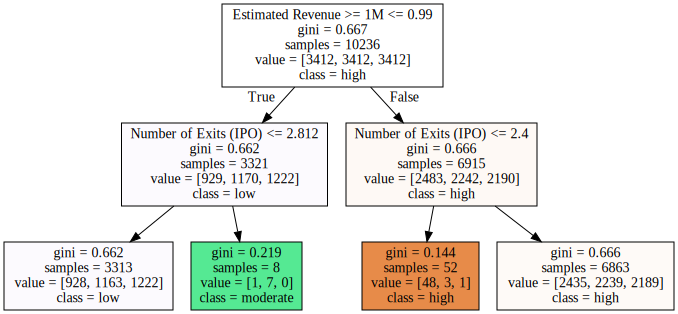

In [ ]:
import graphviz
from sklearn import tree
feature_cols = ['Estimated Revenue >= 1M','Number of Exits (IPO)','Number of Investments']
# DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['high','moderate','low'],filled = True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

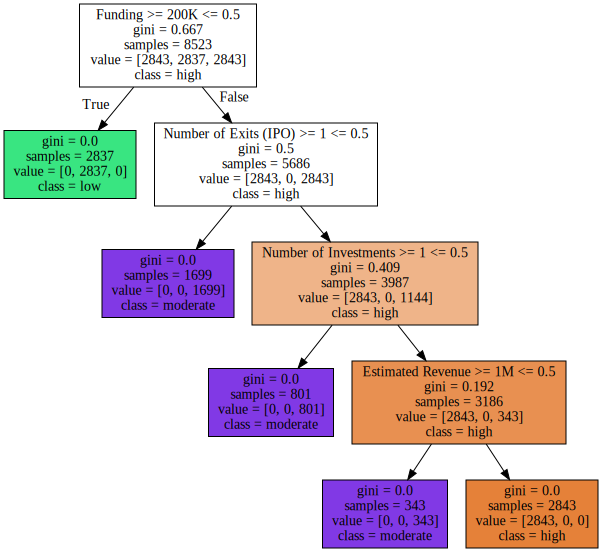

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['high','low','moderate'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Random Forest Regressor - best parameters: {} {'randomforestclassifier__max_depth': 3}
Random Forest Regressor - best mean cross-validation score 0.36283668972996097


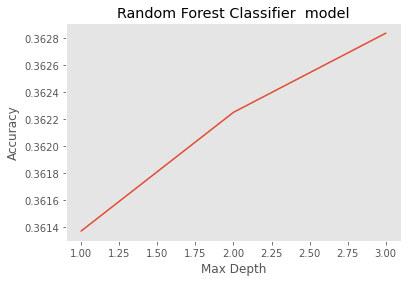

In [ ]:
from sklearn.ensemble import RandomForestClassifier


model_rf = make_pipeline(RandomForestClassifier(n_estimators = 10))
param_grid = {'randomforestclassifier__max_depth':[1,2,3]}
grid_rf = GridSearchCV(model_rf, param_grid = param_grid, return_train_score=True, cv = 10)
grid_rf.fit(X_train_imputed,y_train_imputed)
 
rf_vals = [d['randomforestclassifier__max_depth'] for d in grid_rf.cv_results_['params']]
# plot
plot_graph(rf_vals, grid_rf.cv_results_['mean_test_score'].tolist(), 'Random Forest Classifier  model', 'Max Depth', 'Accuracy', 0, None)


print("Random Forest Regressor - best parameters: {}",grid_rf.best_params_)
print("Random Forest Regressor - best mean cross-validation score",grid_rf.best_score_)

In [ ]:
rf = RandomForestClassifier(max_depth = 2)
rf = rf.fit(X_train_imputed, y_train_imputed)
score = rf.score(X_test_imputed, y_test_imputed)
print(score)

0.7862679955703211


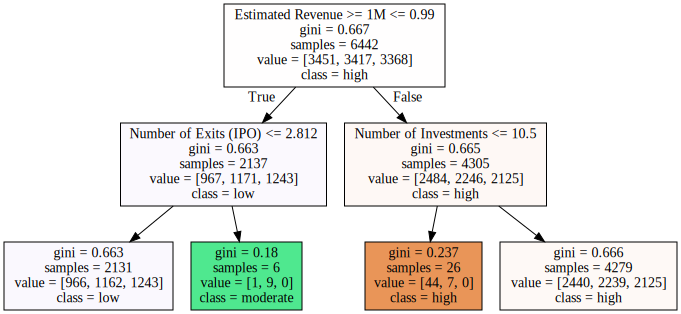

In [ ]:
fimport graphviz
# DOT data
dot_data = tree.export_graphviz(rf.estimators_[3], out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['high','moderate','low'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph